## Machine learning model for predicting the price of gold

The objective of this project is to create a machine learning model that accuratly predicts the price of gold. From looking at https://www.sbcgold.com/blog/10-factors-regularly-influence-gold-prices/, we chose these feature variables as a starting point:

1) Interest rates - To account for interest rates, we took data from 'Market yield on U.S. Treasury securities at 20-year  constant maturity' (i.e. it reflects the amount of interest you pay from a tresury bond issued today in twenty years time).
Data source: https://www.federalreserve.gov/datadownload/Output.aspx?rel=H15&series=bf17364827e38702b42a58cf8eaa3f78&lastobs=&from=&to=&filetype=csv&label=include&layout=seriescolumn&type=package

2) Inflation rates - 
Data source: https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1140&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=T10YIE&scale=left&cosd=2016-01-27&coed=2026-01-23&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2026-01-27&revision_date=2026-01-27&nd=2003-01-02

3) Value of the dollar - US dollar index is taken to account. Data source: https://fred.stlouisfed.org/series/DTWEXBGS

4) S&P500 - A stock market index which tracks the top 500 leading publicly listed companies in America. In a sense tracks the economic performance of USA. Source for data: https://fred.stlouisfed.org/series/SP500

5) Past gold price - It goes without saying that the price of gold the day/ a week / three months before will be colinear with the current gold price. We expect this feature to be the strongest predictor for the future price. Data source: https://freegoldapi.com/


## Other features 

Upon further research, we decided to implement the following additional features:

- University of Michigan: Consumer Sentiment - Captures consumer sentiment. Historically, low confidence has correlated with higher gold prices (source: https://www.mcoscillator.com/learning_center/weekly_chart/gold_and_consumer_sentiment_extremes/). Data source: https://fred.stlouisfed.org/series/UMCSENT

- CBOE Gold ETF Volatility Index -  Aims at capturing the market sentiment and percieved risk of the market via the volatility of the SPDR Gold Shares ETF (GLD). Data source: https://fred.stlouisfed.org/series/GVZCLS

- CBOE Volatility Index: VIX - Captures the volitility of the S&P 500 and is often used by investors as it provides a quantifiable measure  investor fear and uncertainty. Data source: https://fred.stlouisfed.org/series/VIXCLS



## Model/s

We intend to use multiple linear regression to model the data, followed by ARIMAX. In order to track the price gold tommorow/ next week/ in the next three months, We simply take the current price of gold and shift it by 1/ 7/ 31 units. This then serves as the target variable. 

#### Important note:
Given that we are modelling future gold prices using the current gold price as a feature, autocorrelation could be present (this is later confirmed via the durbin watson test and ACF plot). Autocorrelation entails the residuals not being random (i.e. following a pattern). This violates a core assumption of the least squares method (the independence of errors) which leads to an underestimated variance and thus overconfident model. Source: https://economics.town/econometric-methods/consequences-autocorrelation-ols-estimators/

For each of the model types (from 1 to 4), we create two models- one model uses the current gold price as a feature, the other model does not include this feature.

### Model 1

Model 1 aims at predicting the price of gold tommorow. Data is not normalised and ridge regression is not applied.

### Model 2

Model 2 aims at predicting the price of gold after one week. Data is not normalised and ridge regression is not applied.

### Model 3 

Model 3 aims at predicting the price of gold in one months time. Data is not normalised and ridge regression is not applied.

### Model 4 

Model 3 aims at predicting the price of gold in three months time. Data is not normalised and ridge regression is not applied.


### Model 5

Model 4 aims at predicting the price of gold in one months time. This model however, includes the additional features mentioned above, underneath 'Other features'. Data this time is normalised and ridge regression is applied.

We also then conduct tests to verify if the level of autocorrelation between current gold prices and future (lagged) prices.

### Model 6

After confirming the presence of autocorrelation, we looked at producing ARIMAX models which unlike linear regression, are able to take in to account the patterns displayed in the residuals (if present), acount for the correlation between the target and its lagged version of its self (autocorrelation) and finally the seasonal trend. More can be read from: https://www.ibm.com/think/topics/arima-model and https://www.datacamp.com/tutorial/arima


## Plotting and comparing the prices forcasted by the models to the actual price

Models forecast the price of the gold for the month of January 2026. As the project was done during February 2026, we were able to plot the forecasts with the actuall prices.


### Important notes when proceeding with linear regression

As we are dealing with time-series data, are approach in training and testing models have to be changed. All models are trained and tested on the first 90% portion of the data- the other ten percent is kept aside and is used only to predict prices using model 5. This approach ensures fair comparison between all models. A critical step was to change how we split the training and testing data. The conventional train-test split randomly splits the data. Since we are dealing with time-series data, this approach would lead to data leakange as the model will already have an idea of what the future looks like. This would result in a model that is overfitted. Instead, we split the data in a ratio of 67:33 (train test split). This means  models were tested on 33% of the data taken from the tailing end of the dataset which were completly unseen.


In [1]:
# Imports

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing files

interest = pd.read_csv('Interest_rates.csv')
gold = pd.read_csv('Gold_price.csv')
Inlfation_rate = pd.read_csv('Inlfation_rate.csv')
SP500 = pd.read_csv('SP500.csv')
Dollar_index = pd.read_csv('Dollar_index.csv')

### Formatting interest data

In [3]:
interest = interest[['Series Description','Market yield on U.S. Treasury securities at 20-year  constant maturity, quoted on investment basis']]
interest.rename(columns={'Market yield on U.S. Treasury securities at 20-year  constant maturity, quoted on investment basis':'interest_rates'},inplace = True)
interest.rename(columns={'Series Description':'observation_date'},inplace=True)

In [4]:
interest = interest.iloc[5:,:]
interest['observation_date'] = pd.to_datetime(interest.observation_date)

In [5]:
#Dropping ND values 
interest = interest.drop(interest[interest['interest_rates'] == 'ND'].index) 
interest['interest_rates'] = pd.to_numeric(interest.interest_rates)
interest.head(30)

,observation_date,interest_rates
5,1962-01-02,4.07
6,1962-01-03,4.07
7,1962-01-04,4.06
8,1962-01-05,4.07
9,1962-01-08,4.08
10,1962-01-09,4.08
11,1962-01-10,4.09
12,1962-01-11,4.08
13,1962-01-12,4.09
14,1962-01-15,4.10


In [6]:
#Renaming columns

gold.rename(columns={'Value':'gold_price'},inplace=True)
gold.rename(columns={'Date':'observation_date'},inplace=True)
gold['observation_date'] = pd.to_datetime(gold.observation_date)
print(gold.head(),'\n')

Inlfation_rate.rename(columns={'T10YIE':'inflation_rate'},inplace=True)
Inlfation_rate['observation_date'] = pd.to_datetime(Inlfation_rate.observation_date)
print(Inlfation_rate.head(),'\n')

SP500['observation_date'] = pd.to_datetime(SP500.observation_date)
print(SP500.head(),'\n')

Dollar_index.rename(columns={'DTWEXBGS':'dollar_value'},inplace=True)
Dollar_index['observation_date'] = pd.to_datetime(Dollar_index.observation_date)
print(Dollar_index.head(),'\n')

  observation_date  gold_price
0       2016-01-27      1116.3
1       2016-01-28      1116.1
2       2016-01-29      1116.4
3       2016-02-01      1128.0
4       2016-02-02      1127.2 

  observation_date  inflation_rate
0       2016-01-27            1.40
1       2016-01-28            1.42
2       2016-01-29            1.41
3       2016-02-01            1.40
4       2016-02-02            1.36 

  observation_date    SP500
0       2016-01-27  1882.95
1       2016-01-28  1893.36
2       2016-01-29  1940.24
3       2016-02-01  1939.38
4       2016-02-02  1903.03 

  observation_date  dollar_value
0       2016-01-27      115.5087
1       2016-01-28      115.2224
2       2016-01-29      115.5731
3       2016-02-01      115.3331
4       2016-02-02      115.5530 



## Joining data together

In [238]:
df_final = interest.merge(Inlfation_rate, on='observation_date', how='inner').merge(SP500,
on='observation_date',how='inner').merge(Dollar_index, on='observation_date',
how='inner').merge(gold, on='observation_date', how='inner')

df_copy = df_final.copy(deep=True)
'''.merge(SP500,
on='observation_date',how='inner').merge(Dollar_index, on='observation_date',
how='inner').merge(gold, on='observation_date', how='inner')'''

".merge(SP500,\non='observation_date',how='inner').merge(Dollar_index, on='observation_date',\nhow='inner').merge(gold, on='observation_date', how='inner')"

In [239]:
df_final = df_final[df_final['gold_price'] >= 1000]

In [240]:
#Creating target variables
df_final['gold_price_tmw'] = df_final['gold_price'].shift(-1)
df_final['gold_price_nxtweek'] = df_final['gold_price'].shift(-7)
df_final['gold_price_nxtmth'] = df_final['gold_price'].shift(-30)

## Inspecting data

In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2482 entries, 0 to 2481
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   observation_date    2482 non-null   datetime64[ns]
 1   interest_rates      2482 non-null   float64       
 2   inflation_rate      2482 non-null   float64       
 3   SP500               2480 non-null   float64       
 4   dollar_value        2470 non-null   float64       
 5   gold_price          2482 non-null   float64       
 6   gold_price_tmw      2481 non-null   float64       
 7   gold_price_nxtweek  2475 non-null   float64       
 8   gold_price_nxtmth   2452 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 174.6 KB


In [10]:
df_final.head(20)

,observation_date,interest_rates,inflation_rate,SP500,dollar_value,gold_price,gold_price_tmw,gold_price_nxtweek,gold_price_nxtmth
0,2016-01-27,2.42,1.40,1882.95,115.5087,1116.3,1116.1,1157.7,1272.8
1,2016-01-28,2.41,1.42,1893.36,115.2224,1116.1,1116.4,1197.9,1259.4
2,2016-01-29,2.36,1.41,1940.24,115.5731,1116.4,1128.0,1198.6,1245.1
3,2016-02-01,2.38,1.40,1939.38,115.3331,1128.0,1127.2,1194.6,1231.0
4,2016-02-02,2.27,1.36,1903.03,115.5530,1127.2,1141.3,1247.8,1229.8
5,2016-02-03,2.30,1.38,1912.53,114.6144,1141.3,1157.5,1239.4,1265.0
6,2016-02-04,2.29,1.36,1915.45,113.6012,1157.5,1157.7,1208.2,1254.3
7,2016-02-05,2.27,1.33,1880.05,114.2935,1157.7,1197.9,1211.4,1244.2
8,2016-02-08,2.17,1.23,1853.44,114.4351,1197.9,1198.6,1226.3,1250.3
9,2016-02-09,2.16,1.21,1852.21,114.1270,1198.6,1194.6,1230.8,1225.6


In [11]:
df_final.dtypes

observation_date      datetime64[ns]
interest_rates               float64
inflation_rate               float64
SP500                        float64
dollar_value                 float64
gold_price                   float64
gold_price_tmw               float64
gold_price_nxtweek           float64
gold_price_nxtmth            float64
dtype: object

In [12]:
df_final.shape

(2482, 9)

In [243]:
df_final.isnull().sum()

observation_date       0
interest_rates         0
inflation_rate         0
SP500                  2
dollar_value          12
gold_price             0
gold_price_tmw         1
gold_price_nxtweek     7
gold_price_nxtmth     30
dtype: int64

In [244]:
df_final.dropna(inplace=True)
df_final.isnull().sum()

observation_date      0
interest_rates        0
inflation_rate        0
SP500                 0
dollar_value          0
gold_price            0
gold_price_tmw        0
gold_price_nxtweek    0
gold_price_nxtmth     0
dtype: int64

In [15]:
df_final.describe()

,observation_date,interest_rates,inflation_rate,SP500,dollar_value,gold_price,gold_price_tmw,gold_price_nxtweek,gold_price_nxtmth
count,2438,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.00000,2438.000000
mean,2021-01-03 14:07:34.799015680,3.041054,2.055607,3768.543540,117.206680,1823.255195,1824.521156,1832.23521,1863.488625
min,2016-01-27 00:00:00,0.870000,0.500000,1829.080000,106.487700,0.000000,0.000000,0.00000,0.000000
25%,2018-07-12 06:00:00,2.140000,1.770000,2716.972500,113.324450,1303.612500,1304.087500,1305.42500,1311.287500
50%,2021-01-12 12:00:00,2.820000,2.135000,3697.140000,116.393150,1761.000000,1761.450000,1763.77230,1772.550000
75%,2023-06-25 06:00:00,4.140000,2.330000,4511.217500,121.185875,1960.412200,1960.699825,1961.97500,1972.386275
max,2025-12-09 00:00:00,5.300000,3.020000,6890.890000,130.214200,4365.315800,4365.315800,4365.31580,4988.028800
std,NaN,1.140414,0.375689,1271.555336,5.002036,639.357125,641.049958,651.80651,700.036920


## Visualisation

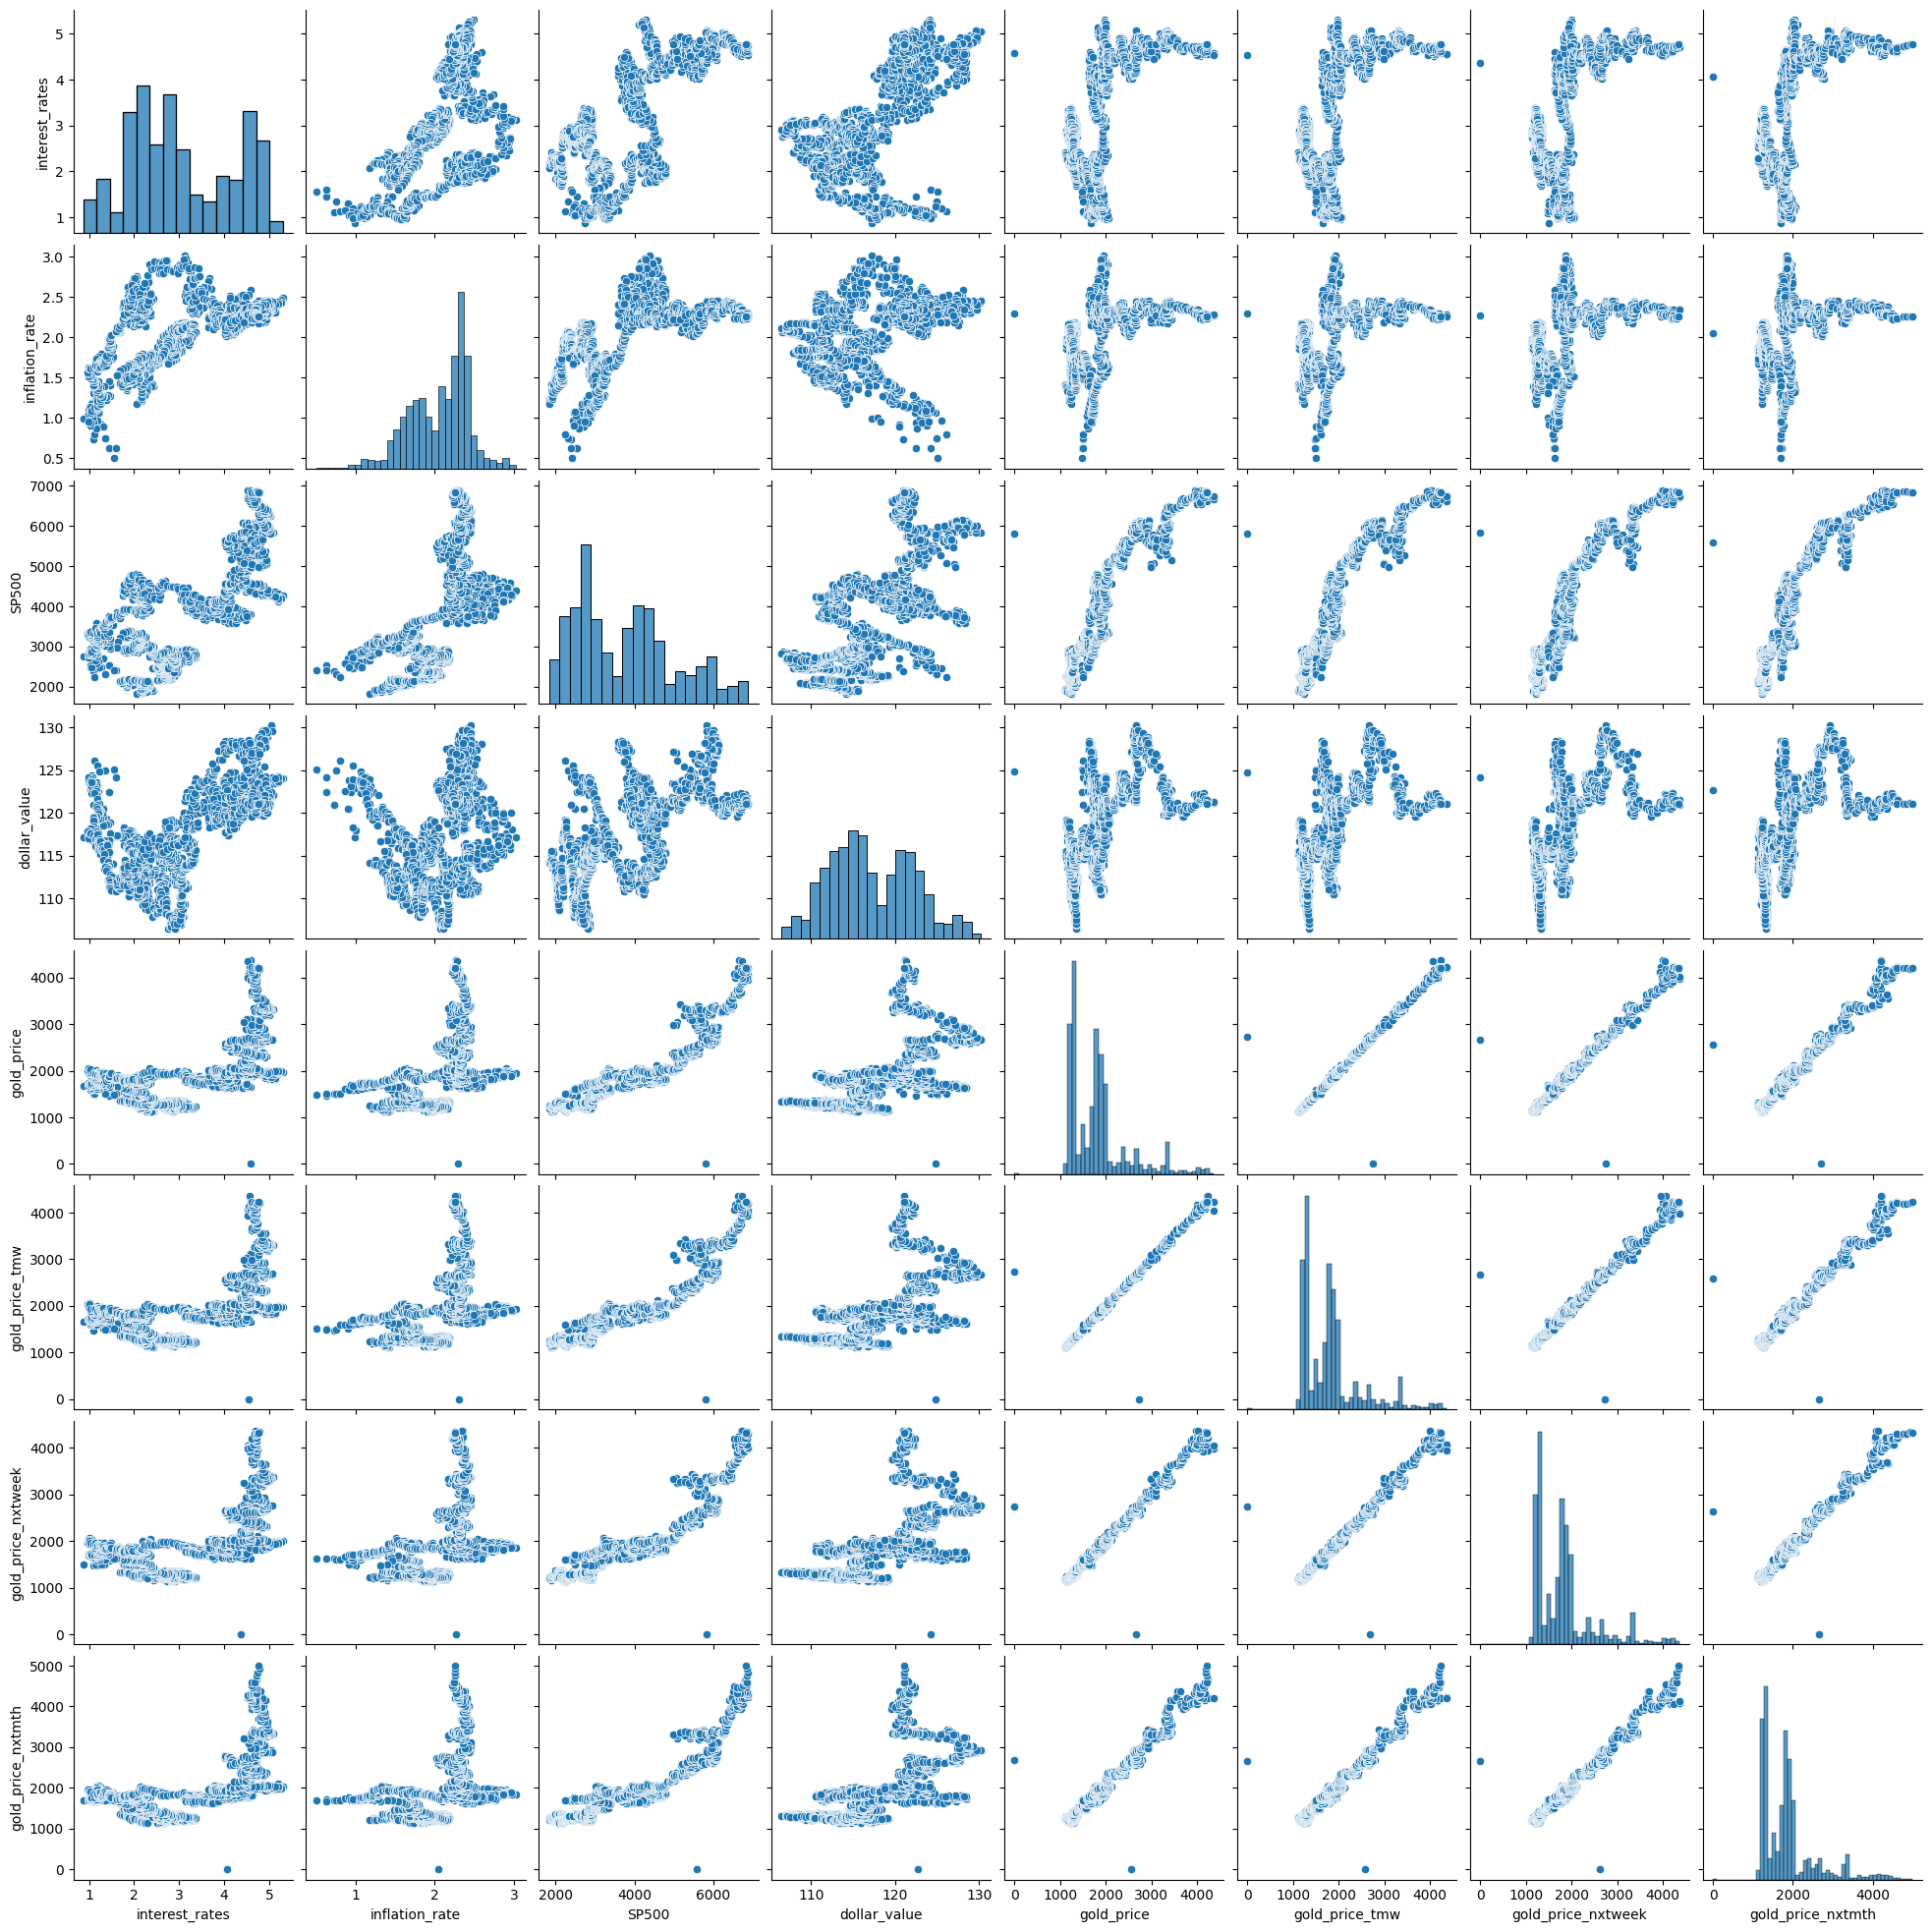

In [16]:
sns.pairplot(df_final)

From the pairplot, we can see signs of multicollinearity between the interest and inflation rates. 

<Axes: >

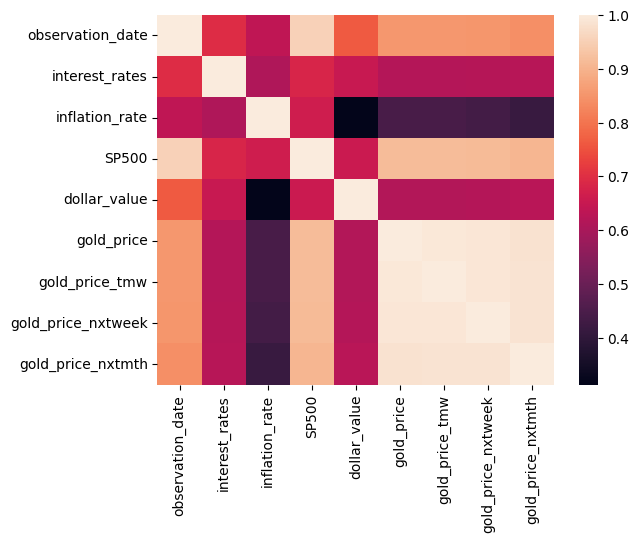

In [17]:
#correlation plot
sns.heatmap(df_final.corr())

In [18]:
df_final.corr()

,observation_date,interest_rates,inflation_rate,SP500,dollar_value,gold_price,gold_price_tmw,gold_price_nxtweek,gold_price_nxtmth
observation_date,1.000000,0.694343,0.636064,0.952637,0.763202,0.853446,0.853081,0.850547,0.840222
interest_rates,0.694343,1.000000,0.609329,0.681528,0.648778,0.617462,0.617644,0.619107,0.622879
inflation_rate,0.636064,0.609329,1.000000,0.663044,0.313155,0.443640,0.442688,0.436532,0.416912
SP500,0.952637,0.681528,0.663044,1.000000,0.656022,0.916308,0.915976,0.913625,0.906081
dollar_value,0.763202,0.648778,0.313155,0.656022,1.000000,0.613761,0.614352,0.617906,0.625208
gold_price,0.853446,0.617462,0.443640,0.916308,0.613761,1.000000,0.991957,0.989648,0.983736
gold_price_tmw,0.853081,0.617644,0.442688,0.915976,0.614352,0.991957,1.000000,0.990014,0.984185
gold_price_nxtweek,0.850547,0.619107,0.436532,0.913625,0.617906,0.989648,0.990014,1.000000,0.986052
gold_price_nxtmth,0.840222,0.622879,0.416912,0.906081,0.625208,0.983736,0.984185,0.986052,1.000000


As expected, the future gold price is heavily correlated to its current price. We note that all other metrics show reasonable correlation with future gold prices, with inflation having the smallest r value of roughly 0.4.

## Model 1: predicting price of gold tomorrow

In [246]:
df_final.dropna(inplace=True)
train_size = int(0.9 * len(df_final))
train_test_set, untouched_set = np.split(df_final, [train_size])

#For fair comparison models will only be trained and tested on the first 90% of data



c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [247]:
# Create a new regressor object for MLR 
# Train the new regressor
mlr_tmw = LinearRegression()
train_size = int(0.67 * len(train_test_set))
train_set, test_set = np.split(train_test_set, [train_size])
X_train = train_set.iloc[:,1:6]
y_train = train_set[['gold_price_tmw']]
X_test = test_set.iloc[:,1:6]
y_test = test_set[['gold_price_tmw']]
mlr_tmw.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [248]:
#checking intercept & coeficients
print(mlr_tmw.intercept_)
print(mlr_tmw.coef_)

[10.96299157]
[[-7.24920924e+00  2.21062761e+00  4.32765477e-03  2.37269558e-01
   9.73972355e-01]]


C:\Users\rahma\AppData\Local\Temp\ipykernel_12776\23990740.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


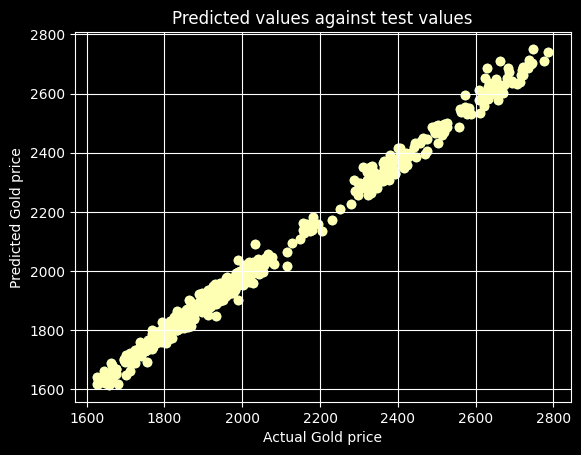

In [249]:
Y_pred = mlr_tmw.predict(X_test)
plt.scatter(y_test,Y_pred)
cmap = plt.get_cmap('Paired')
plt.style.use('dark_background')
plt.scatter(y_test,Y_pred, cmap='Paired')
plt.xlabel("Actual Gold price")
plt.ylabel("Predicted Gold price")
plt.title("Predicted values against test values")
plt.grid(True)

In [250]:

# Evaluation metrics
from sklearn.metrics import mean_absolute_error

mse1 = mean_squared_error(y_test, Y_pred)
rmse1 = np.sqrt(mse1)
r_squared1 = r2_score(y_test, Y_pred)
mae1 = mean_absolute_error(y_test, Y_pred)
print('MSE: ',mse1)
print('RMSE: ', rmse1)
print('MAE: ', mae1)
print('R2:',r_squared1)

MSE:  798.0608824798957
RMSE:  28.24997137131108
MAE:  22.717296758002377
R2: 0.9900313045880401


## model 1.1: removing gold prices
-Gold prices takes a majority weight in the linear model, such that the other features are made redundant.

In [251]:
#defining a function so that we can quickly create models

train_size = int(0.67 * len(train_test_set))
train_set, test_set = np.split(train_test_set, [train_size])


def MLR(x_train,y_train, x_test, y_test):

    mlr = LinearRegression()

    mlr.fit(x_train,y_train)



    print(mlr.intercept_)
    for index, coef in enumerate(mlr.coef_):
      print(x_train.columns[index], coef)

    Y_pred = mlr.predict(x_test)
    cmap = plt.get_cmap('Paired')
    plt.style.use('dark_background')
    plt.scatter(y_test,Y_pred)
    plt.scatter(y_test,Y_pred, cmap='Paired')
    plt.xlabel("Actual Gold price ")
    plt.ylabel("Predicted Gold price ")
    plt.title("Predicted values against test values")
    plt.grid(True)



    mse1 = mean_squared_error(y_test, Y_pred)
    rmse1 = np.sqrt(mse1)
    r_squared1 = r2_score(y_test, Y_pred)
    mae1 = mean_absolute_error(y_test, Y_pred)
    print('MSE: ',mse1)
    print('RMSE: ', rmse1)
    print('MAE: ', mae1)
    print('R2:',r_squared1)

    return mlr

    

c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


1749.8407677842208
interest_rates -268.2393213803398
inflation_rate 54.69953189058191
SP500 0.1883906879643469
dollar_value -2.9768394205856747
MSE:  642017.7513571869
RMSE:  801.2601021872903
MAE:  740.2425524694427
R2: -7.064649316462278


C:\Users\rahma\AppData\Local\Temp\ipykernel_12776\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


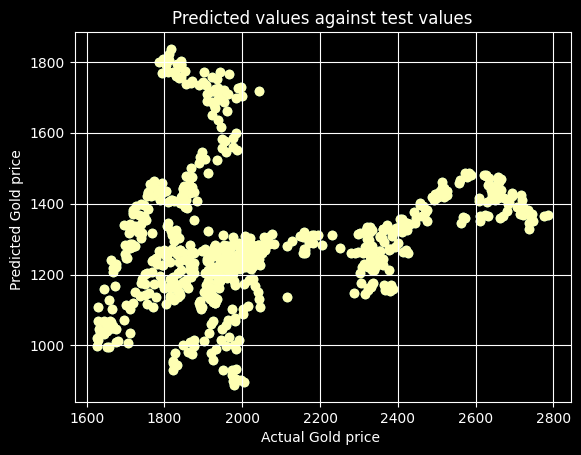

In [252]:
x1_2_train = train_set.iloc[:,1:5]
y1_tmw_train = train_set.iloc[:,-4]
x1_2_test = test_set.iloc[:,1:5]
y1_tmw_test = test_set.iloc[:,-4]
MLR(x1_2_train,y1_tmw_train, x1_2_test, y1_tmw_test)

## Model 2: modelling price prediction for gold in the next week

In [253]:
x1_1_train = train_set.iloc[:,1:6]
y_wk_train = train_set['gold_price_nxtweek']
x1_1_test = test_set.iloc[:,1:6]
y_wk_test = test_set['gold_price_nxtweek']

Model using current gold prices

7.538785314518918
interest_rates -11.374277792060044
inflation_rate -30.236714693610928
SP500 0.03359835983113311
dollar_value 1.1793325609037235
gold_price 0.8930518098303039
MSE:  4028.211094732604
RMSE:  63.46818962860532
MAE:  50.01619893554597
R2: 0.9511707150525484


C:\Users\rahma\AppData\Local\Temp\ipykernel_12776\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


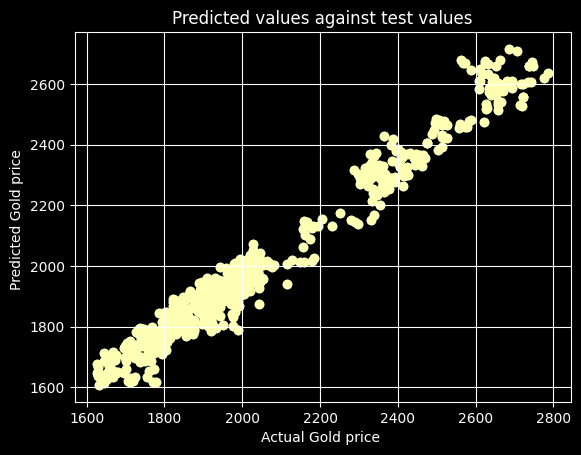

In [254]:
MLR(x1_1_train,y_wk_train,x1_1_test, y_wk_test)

Model without using current gold prices

1570.2372498990915
interest_rates -250.92588921842335
inflation_rate 18.6128012581472
SP500 0.20184100467285737
dollar_value -1.479139271224516
MSE:  573403.893482248
RMSE:  757.2343715668537
MAE:  699.2282773555095
R2: -5.950703785468199


C:\Users\rahma\AppData\Local\Temp\ipykernel_12776\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


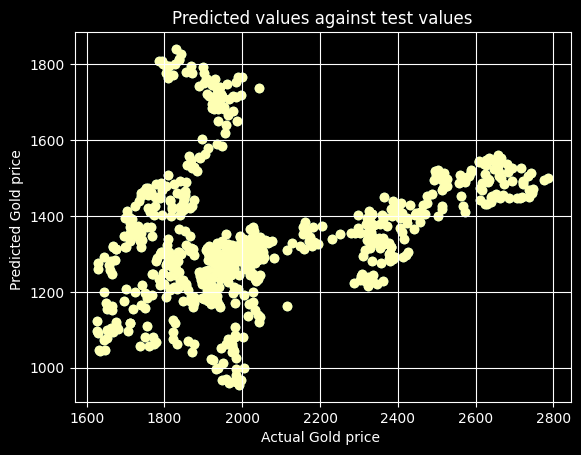

In [255]:
MLR(x1_2_train,y_wk_train,x1_2_test, y_wk_test)

## Modelling gold price next month

In [256]:
y_mnth_test = test_set[['gold_price_nxtmth']]
y_mnth_train = train_set[['gold_price_nxtmth']]

Including current gold prices

[-136.88194403]
interest_rates [ 7.37457090e+00 -1.53482020e+02  1.19724473e-01  4.03112384e+00
  7.29106135e-01]
MSE:  6467.628856594917
RMSE:  80.42156959793135
MAE:  65.58442995237448
R2: 0.930826383011403


C:\Users\rahma\AppData\Local\Temp\ipykernel_12776\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


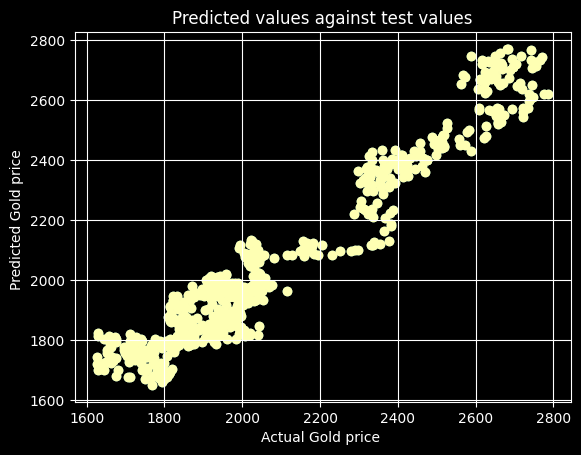

In [257]:
MLR(x1_1_train,y_mnth_train,x1_1_test,y_mnth_test)

Modelling without current gold prices

[1138.93769585]
interest_rates [-188.20036409 -113.60025531    0.25708128    1.86069195]
MSE:  365854.66661318054
RMSE:  604.8592122247793
MAE:  557.2976025725164
R2: -2.9129472551575746


C:\Users\rahma\AppData\Local\Temp\ipykernel_12776\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


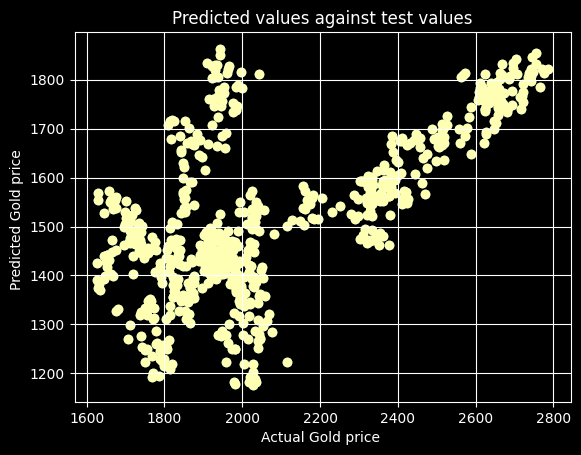

In [258]:
MLR(x1_2_train,y_mnth_train,x1_2_test,y_mnth_test)

## Model 4: Predicting gold price after 3 months

In [32]:
df_final2 = train_test_set
df_final2['gold_price_3mnth'] = df_final2['gold_price'].shift(-91)
df_final2.dropna(inplace=True)
df_final2 = df_final2[df_final2['gold_price_3mnth'] >= 1000]
df_final2 = df_final2.drop(df_final2[df_final2['gold_price_3mnth'] < 1000].index) 

In [33]:
train_size = int(0.67 * len(df_final2))
train_set, test_set = np.split(df_final2, [train_size])
X_train_1 = train_set.iloc[:,1:6]
X_train_2 = train_set.iloc[:,1:5]
y_train_3mnth = train_set[['gold_price_3mnth']]
X_test_1 = test_set.iloc[:,1:6]
X_test_2 = test_set.iloc[:,1:5]
y_test_3mnth = test_set[['gold_price_3mnth']]


c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[-831.0204465]
interest_rates [ -16.72002216 -265.61048786    0.26730488   14.30489065    0.30145393]
MSE:  20925.550227795447
RMSE:  144.65666326787525
MAE:  115.96502786686601
R2: 0.7425685967784148


C:\Users\rahma\AppData\Local\Temp\ipykernel_12776\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


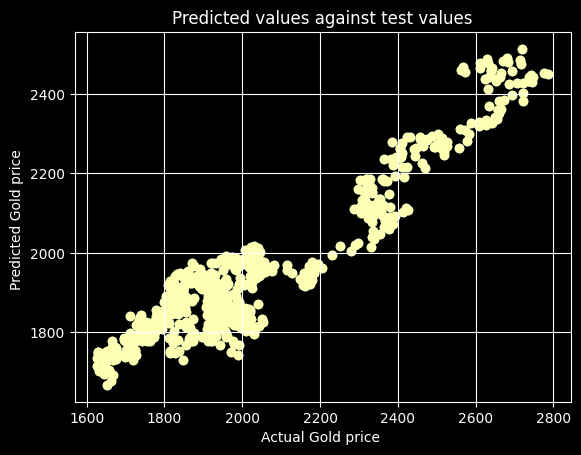

In [34]:
mlr4_1 = MLR(X_train_1,y_train_3mnth,X_test_1,y_test_3mnth )


[-380.84165269]
interest_rates [-101.29472188 -235.11608277    0.32407017   13.94587089]
MSE:  108167.77398262407
RMSE:  328.88869543148496
MAE:  270.613821694462
R2: -0.3307072710907544


C:\Users\rahma\AppData\Local\Temp\ipykernel_12776\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


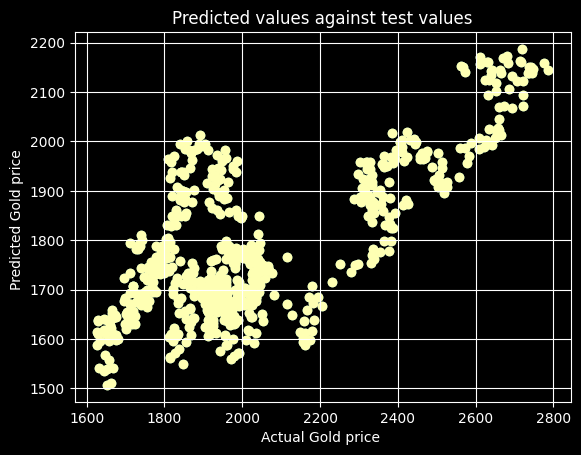

In [35]:
mlr4_2 = MLR(X_train_2,y_train_3mnth,X_test_2,y_test_3mnth)

# Comments on models 1 to 4

As we expected, as the shift of the gold price being predicted increased, the R2 score decreased quite significantly- we this visually represented by the graphs showing the predicted values against the test actual values. For instance, we see a jump from 79 to 573 in the RMSE when moving from model 3 (which predicts prices in 1 month) and model 4 (which predicts prices in 3 months). As model 3 has an R2 of 0.88, we will continue experiment with predicting the price of gold in 1 month.

Predicting the price of gold without the gold feature itself leads to a very weak model- the R2 scores are negative across all models, indicating that the model is performing worse than a model that takes the mean of the target variable. 

## Model 5
Adding  extra features- consumer sentiment score, VIX score and gold volatility. Will look at making predictions in the next 3 months. In addition, this time we will normalise and apply ridge regression normalisation.

In [36]:
consumer_sentiment = pd.read_csv('UMCSENT.csv')
consumer_sentiment.rename(columns={'observation_date':'observation_date_month'},inplace=True)

VIX_score = pd.read_csv('VIXCLS.csv')
Gold_volatility = pd.read_csv('GVZCLS.csv')

In [37]:
consumer_sentiment['observation_date_month'] = pd.to_datetime(consumer_sentiment.observation_date_month)
VIX_score['observation_date'] = pd.to_datetime(VIX_score.observation_date)
Gold_volatility['observation_date'] = pd.to_datetime(Gold_volatility.observation_date)

In [175]:
df_final3 = df_copy.copy(deep=True)

In [176]:
df_final3['observation_date_month'] = df_final3['observation_date'].dt.to_period('M').dt.to_timestamp()

In [177]:
df_final3 = df_final3.merge(consumer_sentiment, on='observation_date_month', how='inner')
df_final3 = df_final3.merge(VIX_score, on='observation_date', how='inner').merge(Gold_volatility, on='observation_date', how='inner')

df_final3.dropna(subset=['SP500', 'dollar_value'], how='any',inplace=True)



In [43]:
df_final3.corr()

,observation_date,interest_rates,inflation_rate,SP500,dollar_value,gold_price,observation_date_month,UMCSENT,VIXCLS,GVZCLS
observation_date,1.000000,0.699083,0.634992,0.952493,0.761845,0.847562,0.999965,-0.843804,0.193324,0.275182
interest_rates,0.699083,1.000000,0.609175,0.686860,0.649173,0.620496,0.699009,-0.540115,-0.213774,-0.105188
inflation_rate,0.634992,0.609175,1.000000,0.658087,0.314412,0.434800,0.634981,-0.583630,-0.125013,-0.119220
SP500,0.952493,0.686860,0.658087,1.000000,0.652700,0.915071,0.952462,-0.780069,0.051510,0.242860
dollar_value,0.761845,0.649173,0.314412,0.652700,1.000000,0.599726,0.761761,-0.695053,0.294406,0.329298
gold_price,0.847562,0.620496,0.434800,0.915071,0.599726,1.000000,0.847522,-0.744472,0.116982,0.409747
observation_date_month,0.999965,0.699009,0.634981,0.952462,0.761761,0.847522,1.000000,-0.843845,0.193399,0.275254
UMCSENT,-0.843804,-0.540115,-0.583630,-0.780069,-0.695053,-0.744472,-0.843845,1.000000,-0.339178,-0.478857
VIXCLS,0.193324,-0.213774,-0.125013,0.051510,0.294406,0.116982,0.193399,-0.339178,1.000000,0.713245
GVZCLS,0.275182,-0.105188,-0.119220,0.242860,0.329298,0.409747,0.275254,-0.478857,0.713245,1.000000


 - The VIX score shows weak level of correlation with the future prices of gold. Gold volatility (GVZCLS) shows improved correlation as we might expect but still remains quite low at ~0.3. Consumer sentiment score (UMCSENT) shows a very correlation with -0.7, indicating that as consumer sentiment rises, gold prices deacrease.

In [178]:
#df_final3 = df_final3[df_final3['gold_price'] <100]
df_final3.drop(df_final3[df_final3['gold_price'] == 0].index, inplace=True)
df_final3['gold_price_mnth'] = df_final3['gold_price'].shift(-30)
train_size_5 = int(0.9 * len(df_final3))
train_test_set_5, untouched_set_5 = np.split(df_final3, [train_size_5])

c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [45]:
train_test_set_5.isnull().sum()

observation_date          0
interest_rates            0
inflation_rate            0
SP500                     0
dollar_value              0
gold_price                0
observation_date_month    0
UMCSENT                   0
VIXCLS                    0
GVZCLS                    0
gold_price_mnth           0
dtype: int64

In [46]:
train_size = int(0.67 * len(train_test_set_5))
train_set, test_set = np.split(train_test_set_5, [train_size])

In [47]:
X_train_1 = train_set[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']]

y_train_mnth = train_set[['gold_price_mnth']]
X_test_1 = test_set[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']]

y_test_mnth = test_set[['gold_price_mnth']]

### Before running the ridge regression function, we first need to find the optimal value for alpha. To do this, we:

In [237]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
X = train_test_set_5[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']]
y = train_test_set_5[['gold_price_mnth']]
alphas = [0, 0.1, 1, 5, 10, 50, 100]
alpha_scores = {}

for alpha in alphas:
    fold_errors = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # scale inside each fold (important!)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)
        fold_errors.append(mean_squared_error(y_test, y_pred))

    alpha_scores[alpha] = np.mean(fold_errors)



best_alpha = min(alpha_scores, key=alpha_scores.get)
print("\nBest alpha:", best_alpha)


Best alpha: 0


In [49]:
# Creating an augmented MLR function that includes ridge regression 

def MLR_ridge(x_train, y_train, x_test, y_test):

    mlr = Ridge(alpha=0)
    
    feature_scaler = StandardScaler()
    scaler3 = StandardScaler()
    scaler3.fit_transform(x_train)               # fit ONLY on training data

    X_train_scaled = scaler3.transform(x_train)
    X_test_scaled  = scaler3.transform(x_test)
    mlr.fit(X_train_scaled,y_train)



    print(mlr.intercept_)
    for index, coef in enumerate(mlr.coef_):
     print(x_train.columns[index], coef)
    y_test_array = y_test.values.ravel()
    Y_pred = mlr.predict(X_test_scaled)
    y_test_array = y_test.values.ravel()
    residual = y_test_array - Y_pred
    #cmap = plt.get_cmap('Set2')
    plt.style.use('dark_background')
    plt.scatter(y_test,Y_pred)
    plt.xlabel("Actual Gold price in a month")
    plt.ylabel("Predicted Gold price in a month")
    plt.title("Predicted values against actual values")
    plt.grid(True)


    mse1 = mean_squared_error(y_test, Y_pred)
    rmse1 = np.sqrt(mse1)
    r_squared1 = r2_score(y_test, Y_pred)
    mae1 = mean_absolute_error(y_test, Y_pred)
    print('\n')
    print('MSE: ',mse1)
    print('RMSE: ', rmse1)
    print('MAE: ', mae1)
    print('R2:',r_squared1)

    return mlr, scaler3, residual 

Model with current price of gold as feature, using ridge regression:
[1480.18104195]
interest_rates -4.000369089742808
inflation_rate -43.83982481332556
SP500 86.0113431414868
dollar_value 10.710814670209414
gold_price 171.77746521938224
UMCSENT -1.7007107866783282
VIXCLS 15.524001085620775
GVZCLS -5.614637869324742


MSE:  11551.882241713454
RMSE:  107.47968292525547
MAE:  83.12732225107253
R2: 0.8894157754533426




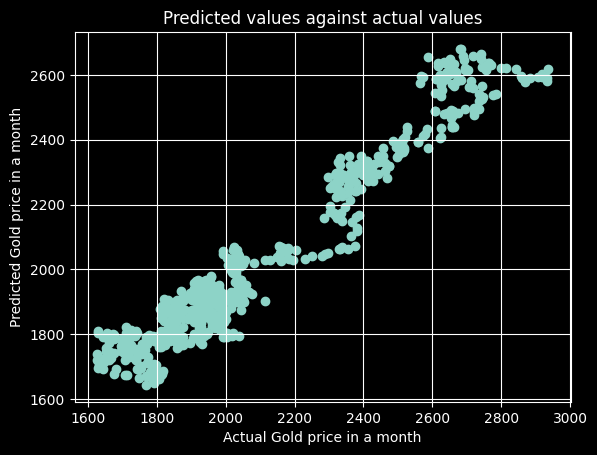

In [ ]:
#testing alpha = 0.1
print('Model with current price of gold as feature, using ridge regression:')
mlr5_1, scaler1 , residual1= MLR_ridge(X_train_1,y_train_mnth,X_test_1,y_test_mnth)
print('\n')


This model (model 5.1) has a slightly better R2 than the R2 in model 3.1 (0.888 vs 0.88). However, the RMSE error is greater in model 5.1 (108 against 79). This indicates that model 5.1 generalizes the data better, however ultimatly fails to make the better predictions. It may be due to noise introduced via the new feature variables, or because of ridge regression penalising the larger weights (i.e the current gold price). By changing the alpha value to zero (analogous to linear regression), we get:

Model with current price of gold as feature, using ridge regression:
[1480.18104195]
interest_rates -4.000369089742808
inflation_rate -43.83982481332556
SP500 86.0113431414868
dollar_value 10.710814670209414
gold_price 171.77746521938224
UMCSENT -1.7007107866783282
VIXCLS 15.524001085620775
GVZCLS -5.614637869324742


MSE:  11551.882241713454
RMSE:  107.47968292525547
MAE:  83.12732225107253
R2: 0.8894157754533426




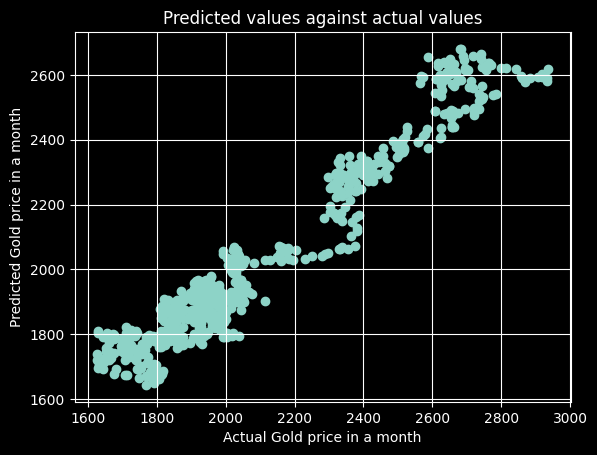

In [52]:
print('Model with current price of gold as feature, using ridge regression:')
mlr5_1, scaler1 , residual1= MLR_ridge(X_train_1,y_train_mnth,X_test_1,y_test_mnth)
print('\n')

The R2 value slightly improves even more without ridge regression, but the RMSE score still remains high.

#### Training model 5.1 (with linear regression) on entire historical data and using that to forecast the price of gold in the coming month (from which dataset ends)

In [179]:
#features_scaled = scaler1.transform(untouched_set_5[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']])
#untouched_set_5['gold_price_mnth_model5.1'] = mlr5_1.predict(features_scaled)

#mlr5_1_final, scaler1 , residual1= MLR_ridge(X_train_1,y_train_mnth,X_test_1,y_test_mnth)

training_final = df_final3.dropna(subset=['gold_price_mnth'])
Y_train_final = training_final['gold_price_mnth']
training_final = training_final[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']]
test_final = df_final3[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']].tail(30)


df_final3['observation_date'] = pd.to_datetime(df_final3['observation_date'])
future_dates = []
for i in range(1,31):
    future_dates.append(df_final3['observation_date'][2466]+pd.DateOffset(days=i))
future_dates = pd.DataFrame(future_dates)


mlr5_1_final = LinearRegression()
    
feature_scaler = StandardScaler()
scaler3 = StandardScaler()
scaler3.fit_transform(training_final)               

X_train_scaled = scaler3.transform(training_final)
X_test_scaled  = scaler3.transform(test_final)
mlr5_1_final.fit(X_train_scaled,Y_train_final)
Y_pred_final = mlr5_1_final.predict(X_test_scaled)



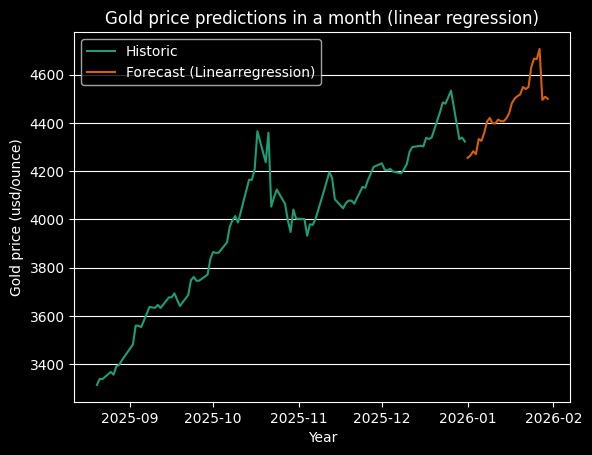

In [180]:
cmap = plt.get_cmap('Dark2')
plt.style.use('dark_background')
plt.plot(df_final3['observation_date'].tail(91),df_final3['gold_price'].tail(91), label = 'Historic', color=cmap(0))
plt.plot(future_dates, Y_pred_final, label = 'Forecast (Linearregression)', color=cmap(1))
plt.xlabel("Year")
plt.ylabel("Gold price (usd/ounce)")
plt.title("Gold price predictions in a month (linear regression)")
plt.grid(axis = 'y')
plt.legend()


## Model evaluation of model 5.1 

Markets are closed on new years eve, hense why there is a gap between the historic and forecast data.

The shapes of the peaks and dips in the forecasted price seem very similar to the shapes of tail end of the historic gold price. This is indication that the feature values have not changed much, thus leading this similarity.

#### Durbin Watson test

In [55]:
from statsmodels.stats.stattools import durbin_watson

In [56]:
print('Durbin watson test on model 5.1: ',durbin_watson(residual1),'\n')

Durbin watson test on model 5.1:  0.051917914883088244 



#### ACF plot

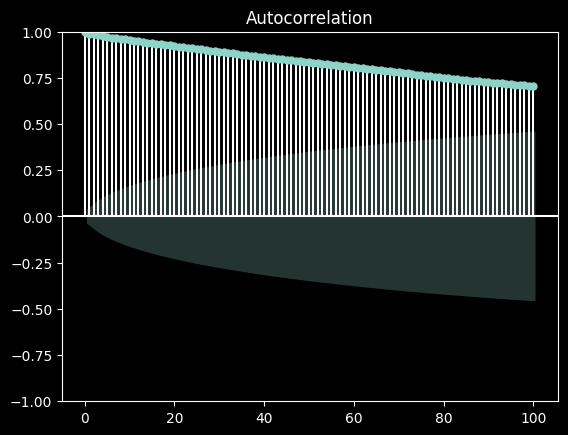

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
# Compute autocorrelation
acf_values = sm.tsa.acf(gold['gold_price'], nlags=100)

# Plot the results
sm.graphics.tsa.plot_acf(gold['gold_price'], lags=100)
plt.show()



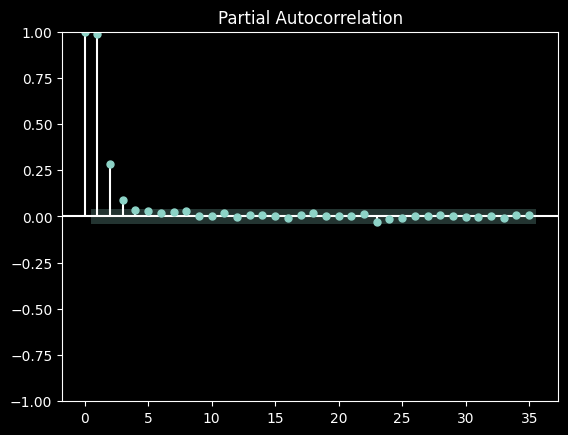

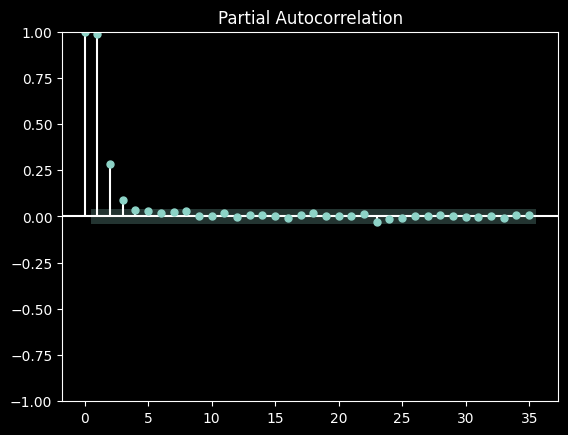

In [229]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(gold['gold_price'])

The durbin watson test would indicate that there is presence of positive autocorrelation as the output value is less 2. The ACF plot also shows that a lag of 30 days yields an autocorrelation value outside the confidence interval range, signifying autocorrelation. Moreover the fact that the autocorrelation declines slowly as opposed to sharply decreasing below the confidence interval suggests that there is a trend within the data (i.e. It is not stationary).

 Source for more information: https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/

## Model 6.1 - ARIMAX model

ARIMA (Autoregressive Integrated Moving Average) models are often used for dealing with time-series data. As we also have additional features apart from the gold price itself, we use the ARIMAX model (the X stands for Exogenous Variables). To estimate the best values for p,d,q, we explore using a brute force gridsearch aimed at minimizing the MSE and auto_arima, which uses the AIC criterion.

Since ARMIAX handles forecasts of future events internally, it does not require a shifted target label.

In [ ]:
#Finding the p,d,q values which minimize MSE
#Note: 'x_train' & 'x_test' in this context refers to the treatment of exogenous variables, 
# whereas 'y_train' & 'y_test' refers to the time-series we are evaluating and trying to forecast.
from statsmodels.tsa.statespace.sarimax import SARIMAX
X_train_arimax = X_train_1[['interest_rates','inflation_rate','SP500','dollar_value','UMCSENT','VIXCLS','GVZCLS']]
X_test_arimax = X_test_1[['interest_rates','inflation_rate','SP500','dollar_value','UMCSENT','VIXCLS','GVZCLS']]
y_train_arimax = X_train_1[['gold_price']]
y_test_arimax = X_test_1[['gold_price']]

#X_train_1,y_train_mnth,X_test_1,y_test_mnth
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 10)
q_values = range(0, 10)
order_dict = {}
for p in p_values:
    for d in d_values:
        for q in q_values:
                order = (p,d,q)
                # scale inside each fold (note this step is not needed for ARIMA)
                #scaler = StandardScaler()
                #X_train_scaled = scaler.fit_transform(X_train_arimax)
                #X_test_scaled = scaler.transform(X_test_arimax)
                try: 
                    model = SARIMAX(y_train_arimax, exog=X_train_arimax, order=order)
                    results = model.fit()
                    forecast = results.forecast(steps=30, exog=X_test_arimax[-30:])
                    mse = mean_squared_error(y_test_arimax[-30:], forecast)
                    order_dict.update({order:mse})
                except:
                     continue

best_pdq = min(order_dict, key=order_dict.get)
print('\nBest pdq values: ', best_pdq)
                
           
                


In [ ]:
#%pip install pmdarima

In [227]:
#Using arima_auto to find the best order values
from pmdarima import auto_arima
model = auto_arima(
    y_train_arimax, 
    exogenous=X_train_arimax,
    seasonal=False,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12023.561, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12025.552, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12025.552, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12023.112, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12027.557, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.939 seconds


#### As the two methods for finding the optimal values for p,d,q differ, we will fit both models on the entire dataset. UPDATE: the best values produced from the brute force gridsearch resulted in forecasted predictions that were way off. This result perhaps emphasises the importance of using AIC.

To make forecasts, we will need the future values for the exogenous variables- since we obviously do not have access to them, a possible solution is to forecast each of the exogenous variables.

### Forecasting exogenous variables

In [ ]:
exogenous_variables = df_final3[['interest_rates','inflation_rate','SP500','dollar_value','UMCSENT','VIXCLS','GVZCLS']]
from statsmodels.tsa.arima.model import ARIMA

#finding optimal p,d,q values for each feature/exogenous variable and then running ARIMA forecast for the variables
exogenous_forecast = pd.DataFrame()
for column in exogenous_variables:
    
    columnSeriesObj = exogenous_variables[column]
    #print(column,":")
    model = auto_arima(
    columnSeriesObj.values,
    seasonal=False,
    trace=True);
    p, d, q = model.order
    model = ARIMA(exogenous_variables[column],order=(p,d,q))
    results = model.fit()
    exogenous_forecast[column] = results.forecast(steps=30)
   


## Forecasting the ARIMAX model

In [74]:
X_train_arimax6_1 = df_final3[['interest_rates','inflation_rate','SP500','dollar_value','UMCSENT','VIXCLS','GVZCLS']]
y_train_arimax6_1 = df_final3[['gold_price']]


In [235]:
from statsmodels.tsa.arima.model import ARIMA
model = SARIMAX(y_train_arimax6_1, exog=X_train_arimax6_1, order=(0,1,0))
results = model.fit()
forecast = results.get_forecast(steps=30, exog=exogenous_forecast)
forecast_values = forecast.predicted_mean


c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

### Plotting the prediction from the ARIMAX model and linear regression model with the actual price that occured on the forecasted dates.

In [ ]:
#Sourcing the actual price of gold using Yfinance
import yfinance as yf
gold_ticker = 'GC=F'
gold_data = yf.download(gold_ticker, start="2026-01-01", end="2026-01-30")

(2452, 11)

In [129]:
df_final3['observation_date'] = pd.to_datetime(df_final3['observation_date'])
df_final3['observation_date'] = pd.to_datetime(df_final3['observation_date'])

future_dates = []
for i in range(1,31):
    future_dates.append(df_final3['observation_date'][2466]+pd.DateOffset(days=i))

future_dates = pd.DataFrame(future_dates)


#### Plotting

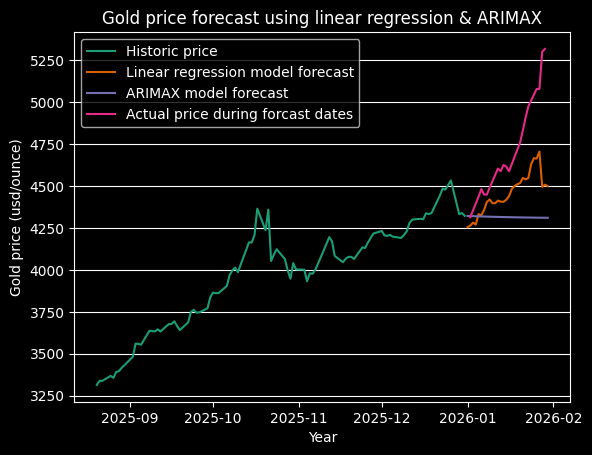

In [236]:
cmap = plt.get_cmap('Dark2')
plt.style.use('dark_background')
plt.plot(df_final3['observation_date'].tail(91),df_final3['gold_price'].tail(91), label = 'Historic price', color=cmap(0))
plt.plot(future_dates, Y_pred_final, label = 'Linear regression model forecast', color=cmap(1))
plt.plot(future_dates, forecast_values, color=cmap(2), label = 'ARIMAX model forecast')
plt.plot(gold_data['Close'], color=cmap(3), label = 'Actual price during forcast dates')
plt.xlabel("Year")
plt.ylabel("Gold price (usd/ounce)")
plt.title("Gold price forecast using linear regression & ARIMAX")
plt.grid(axis = 'y')
plt.legend()


#plt.plot(df_final3['observation_date'].tail(91),y_train_arimax6_1.tail(91))


# Evaluation

The graph above illistrates the difficulty in predicting the future price of gold, given its incredible volatility in recent times. Similarly to the ARIMA model forecast of gold from https://www.datacamp.com/tutorial/arima, the ARIMAX model forecast is also a flat line. The linear regression model does perform better, however was also incapable of predicting the massive spike.

# What was learnt

Althought models were not able to reflect the volatility of gold, many things were learnt regardless from this project:

- Gathering useful features and combining merging them using pandas to produce a comprehensive dataset.

- Learnt how to deal with time-series data, and specifically how train and test split must be done to prevent data leakage. 

- Used timeseries split to tune hyperparameters for ridge regression (alpha value)

- Learnt about autocorrelation, and how they influence our perception of model performance. Tested for autocorrelation using Durbin Watson test and explored ACF & PACF plots.

- Introduced to ARIMA  models, and their different components, and how they evaluate patterns in data. 

- Applied an ARIMAX model which used exogenous variables. Forecasted each of the exogenous variables using ARIMA (tuned p,d,q values using auto_arima) so that they can  be used for 30 day forecast.


# Future areas of work

- See what happens when ARIMAX forecasts are extended beyond 30 days.

- As opposed to looking at gold prices per day, could try modelling how prices change per hour and see if there are seasonal trends (i.e. at times when different markets open), requiring the use of SARIMAX.